In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
btc = web.get_data_yahoo('BTC-USD', 
                         start=datetime.datetime(2017, 1, 1),
                        end=datetime.datetime(2017, 12, 27))
btc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.380005,1001.609985,956.099976,995.440002,995.440002,40570922
2017-01-02,995.440002,1031.680054,990.200012,1017.049988,1017.049988,66038073
2017-01-03,1017.049988,1035.469971,1006.530029,1033.300049,1033.300049,56085870
2017-01-04,1033.300049,1148.540039,1022.320007,1135.410034,1135.410034,170584623
2017-01-05,1135.410034,1150.630005,874.530029,989.349976,989.349976,244839289


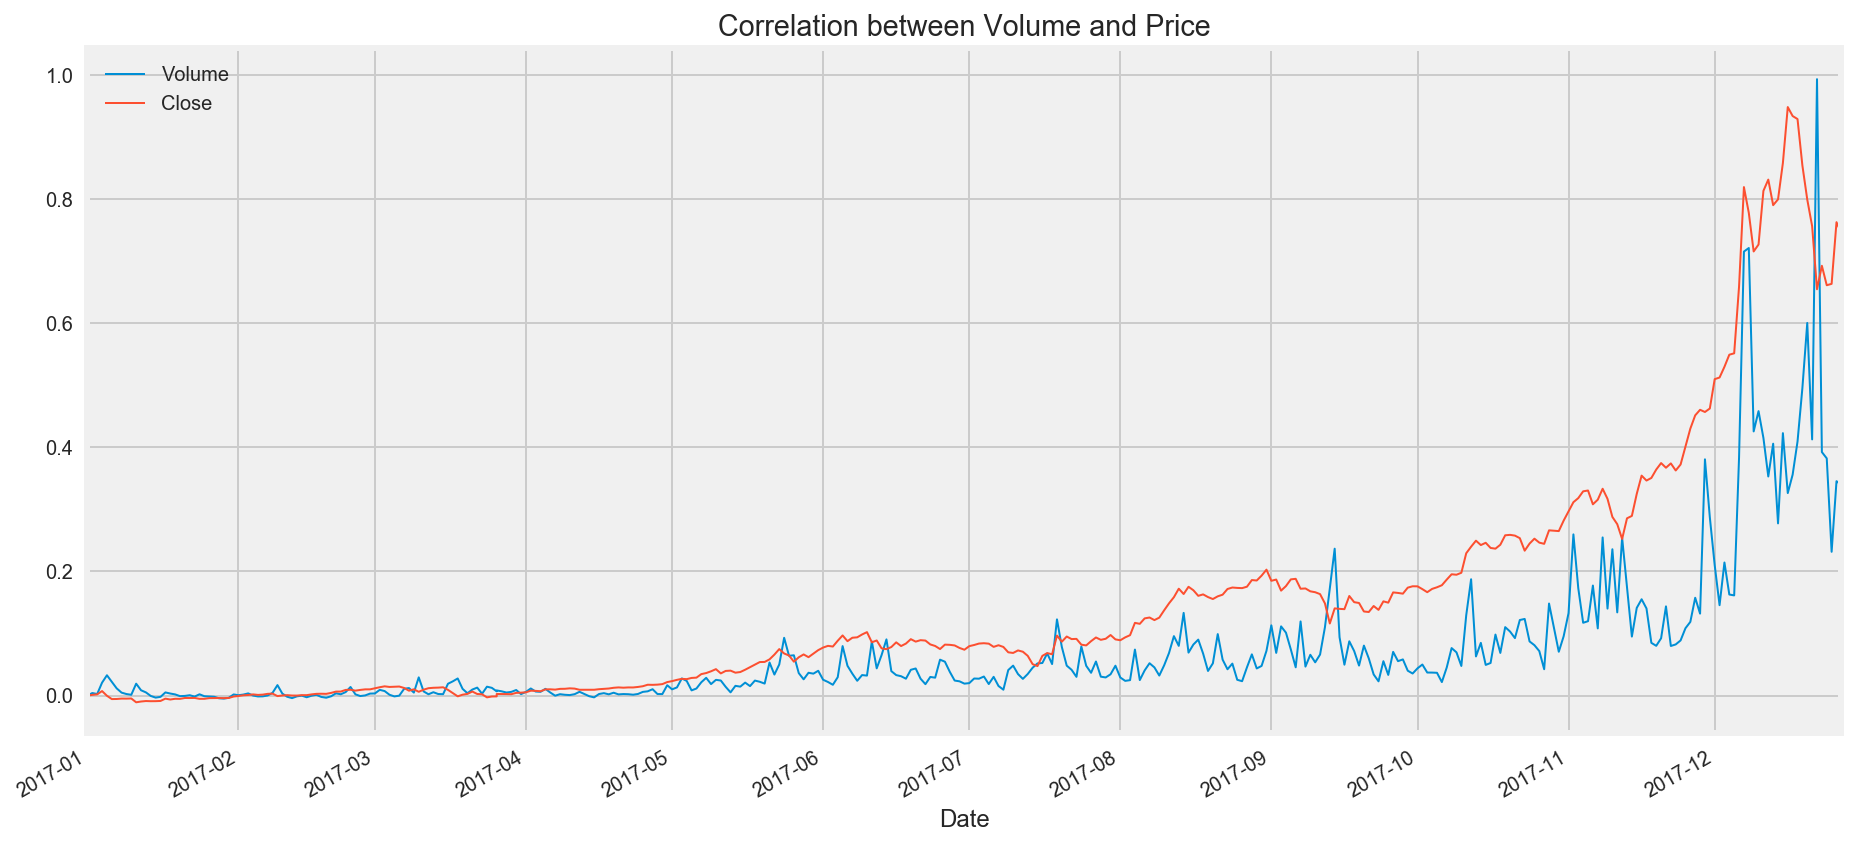

In [4]:
plt.figure(figsize = (14,7))
((btc.Volume-btc.Volume[0])/btc.Volume.max()).plot(lw = 1)
((btc.Close-btc.Close[0])/btc.Close.max()).plot(lw = 1)
plt.title("Correlation between Volume and Price")
plt.legend(loc='upper left')
plt.show()

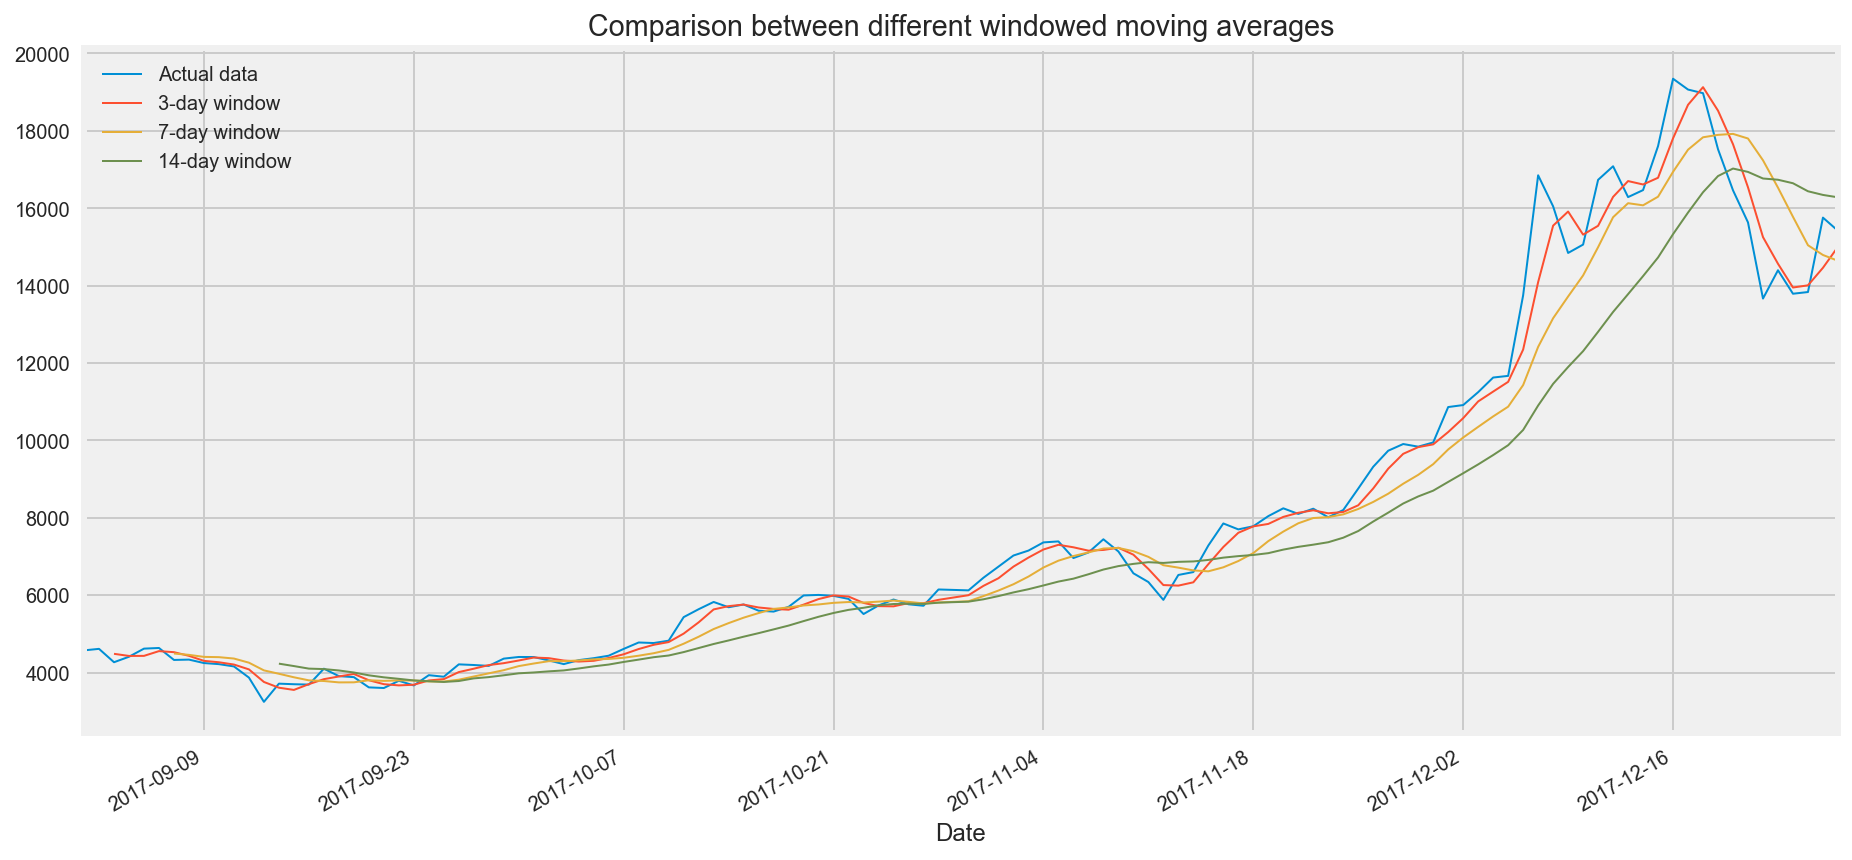

In [5]:
btc_close = btc.Close
btc_recent = btc_close.loc['2017-09-01':'2017-12-27']

MA_3d = btc_recent.rolling(window=3).mean()
MA_7d = btc_recent.rolling(window=7).mean()
MA_14d = btc_recent.rolling(window=14).mean()

plt.figure(figsize = (14,7))
btc_recent.plot(lw = 1, label='Actual data')
MA_3d.plot(lw = 1, label='3-day window')
MA_7d.plot(lw = 1, label='7-day window')
MA_14d.plot(lw = 1, label='14-day window')
plt.legend(loc='upper left')
plt.title('Comparison between different windowed moving averages')
plt.show()

### Dual Moving Average Crossover
trade when the short term average value crosses the long term one

In [7]:
short_window = 10
mid_window = 50

MA_short = btc_close.rolling(window = short_window).mean()
MA_mid = btc_close.rolling(window = mid_window).mean()

signals = pd.DataFrame(index=btc_close.index)
signals['short'] = MA_short
signals['mid'] = MA_mid
signals['signal'] = 0.0
signals['signal'][short_window:] = np.where(
    signals['short'][short_window:] > signals['mid'][short_window:],
    1,0)
signals['positions'] = signals['signal'].diff()

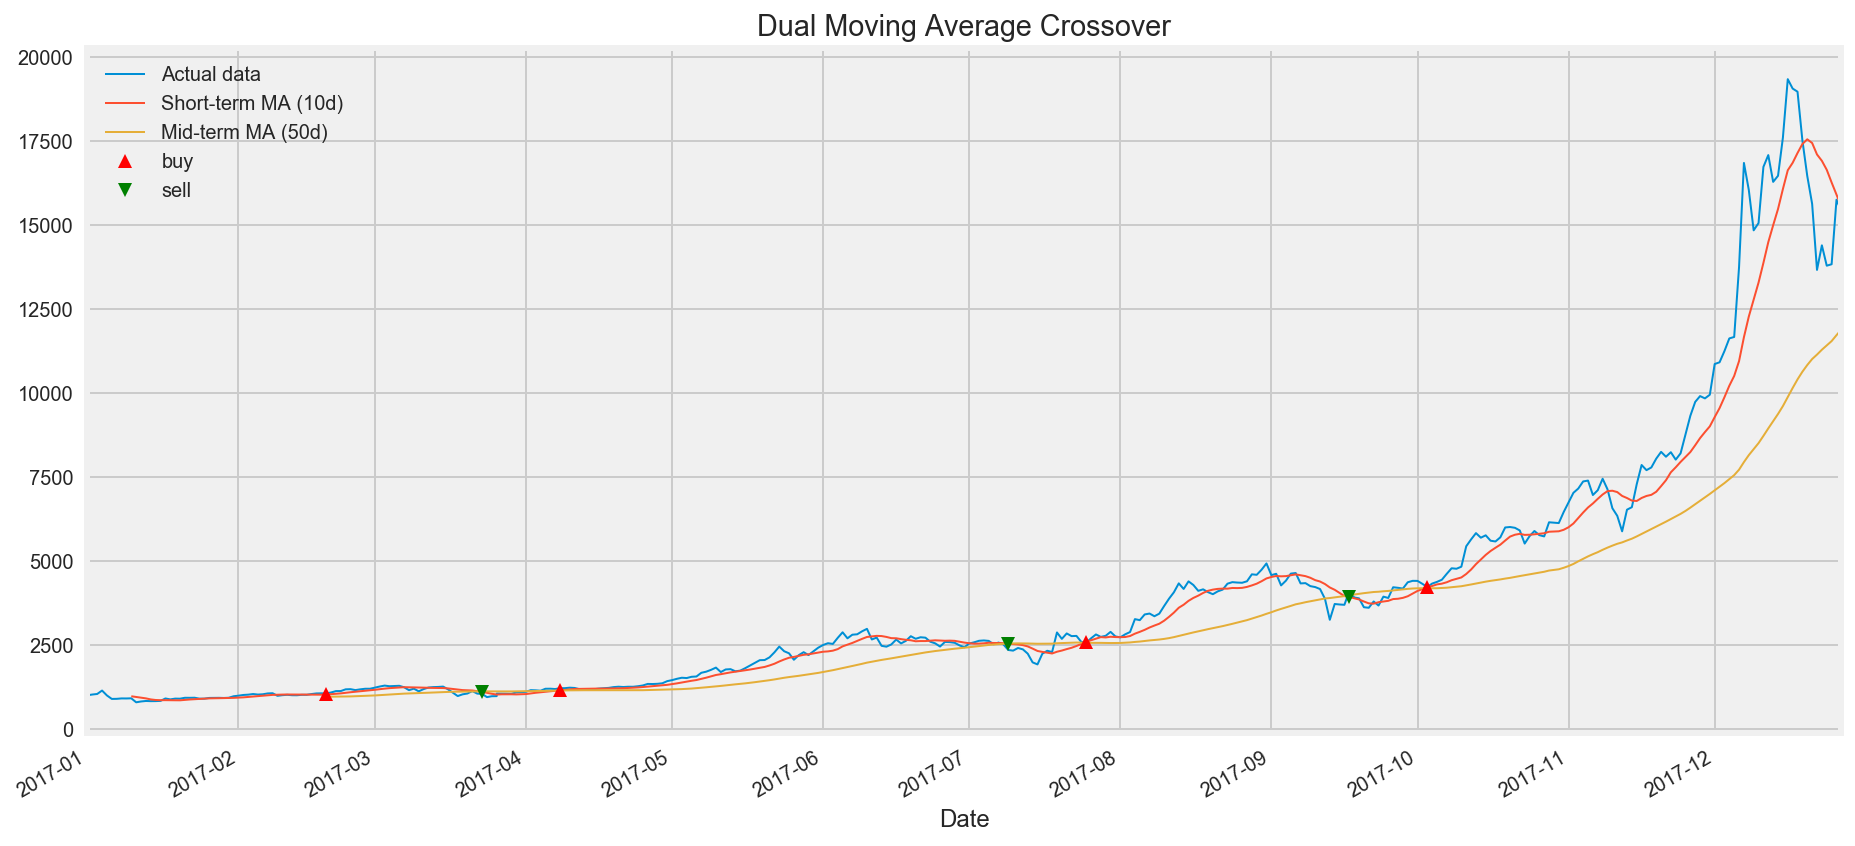

In [8]:
plt.figure(figsize = (14,7))
btc_close.plot(lw=1, label = 'Actual data')
MA_short.plot(lw=1, label='Short-term MA (10d)')
MA_mid.plot(lw=1, label='Mid-term MA (50d)')

plt.plot(signals[signals.positions == 1].short,
        '^',color='r',label = 'buy')
plt.plot(signals[signals.positions == -1].short,
         'v',color='g', label = 'sell')

plt.legend(loc='upper left')
plt.title("Dual Moving Average Crossover")


plt.show()

In [9]:
bought = -btc_close[signals.positions == 1].sum()
sold = btc_close[signals.positions == -1].sum()
#minor correction: if the last action was sell the current value is neg.
current_value = btc_close[-1]*signals[signals.positions!=0].positions[-1]
print("Asset value: {0:.2f}".format(bought + sold + current_value))

Asset value: 13864.87


In [10]:
#All in a function that only receives the windows
def DMAC_trading_return(btc_close, short_window = 10, mid_window = 50,with_plot=True):
    MA_short = btc_close.rolling(window = short_window).mean()
    MA_mid = btc_close.rolling(window = mid_window).mean()

    signals = pd.DataFrame(index=btc_close.index)
    signals['short'] = MA_short
    signals['mid'] = MA_mid
    signals['close']=btc_close
    signals['signal'] = 0.0
    signals['signal'][short_window:] = np.where(
        signals['short'][short_window:] > signals['mid'][short_window:],
        1,0)
    signals['positions'] = signals['signal'].diff()
    
    
    bought = -btc_close[signals.positions == 1].sum()
    sold = btc_close[signals.positions == -1].sum()
    current_value = btc_close[-1]*signals[signals.positions!=0].positions[-1]
    
    if with_plot:
        plt.figure(figsize = (14,7))
        btc_close.plot(lw=1, label = 'Actual data')
        MA_short.plot(lw=1, label='Short-term MA ({}d)'.format(short_window))
        MA_mid.plot(lw=1, label='Mid-term MA ({}d)'.format(mid_window))

        plt.plot(signals[signals.positions == 1].close,
            '^',color='r',label = 'buy')
        plt.plot(signals[signals.positions == -1].close,
             'v',color='g', label = 'sell')

        plt.legend(loc='upper left')
        plt.title("Dual Moving Average Crossover")

        plt.show()

        print("Asset value: {0:.2f}".format(bought + sold + current_value))
    return bought + sold + current_value

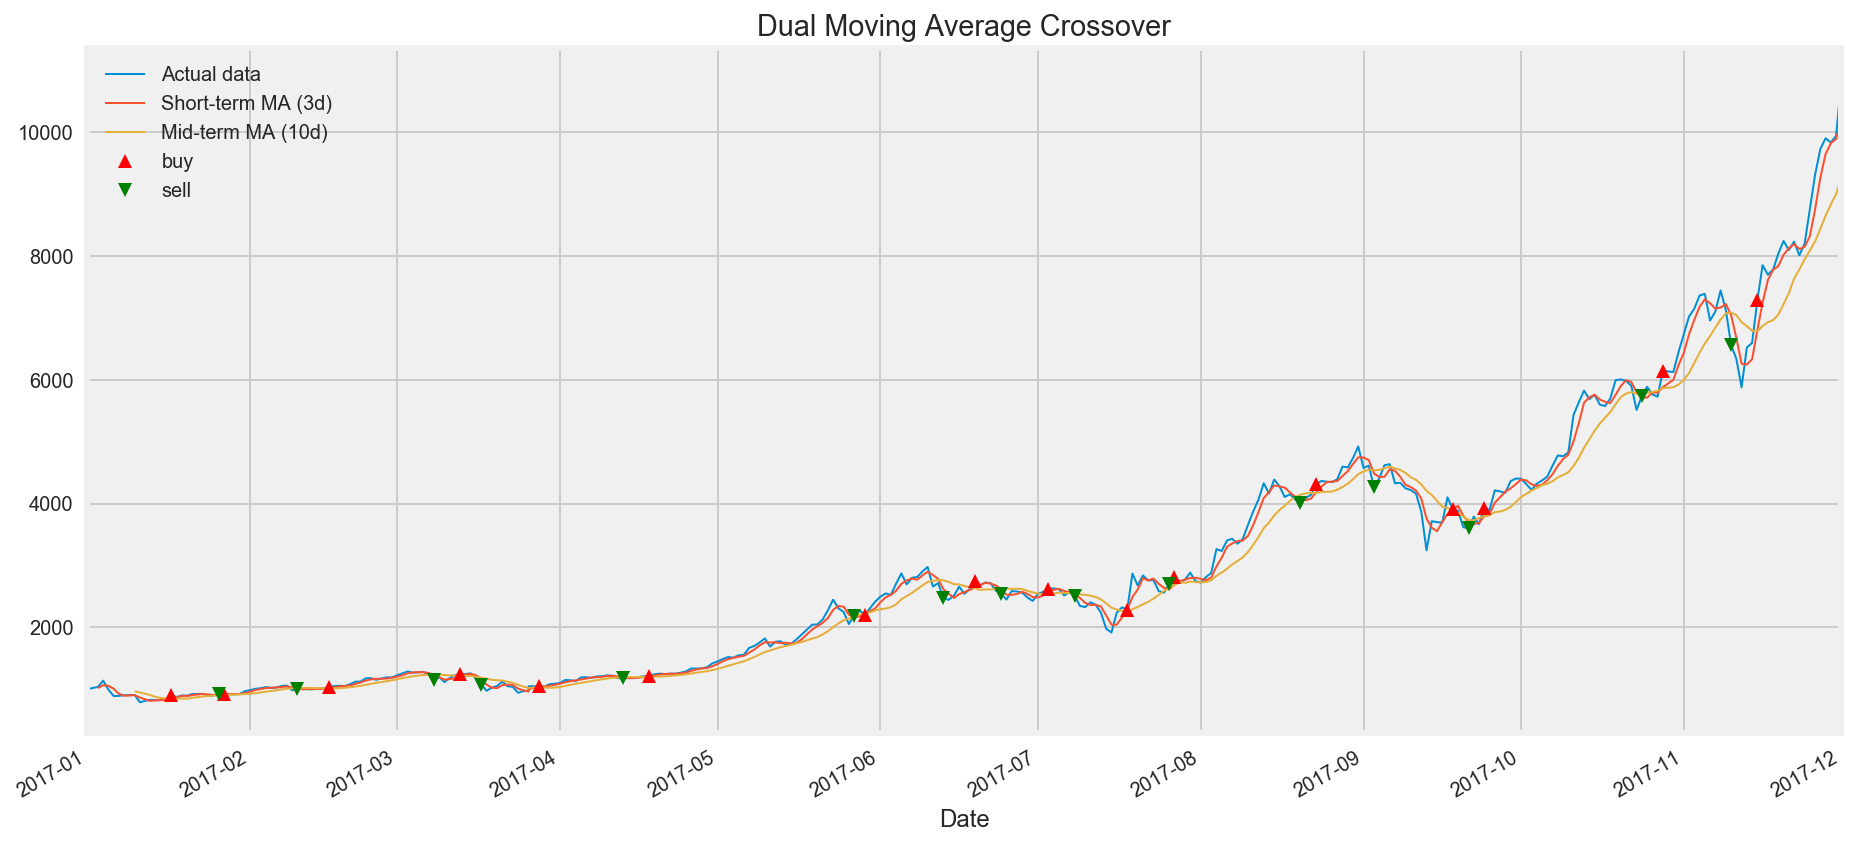

Asset value: 8156.70


8156.6993430000039

In [20]:
DMAC_trading_return(btc_close.loc[:'2017-12-01'],3,10)

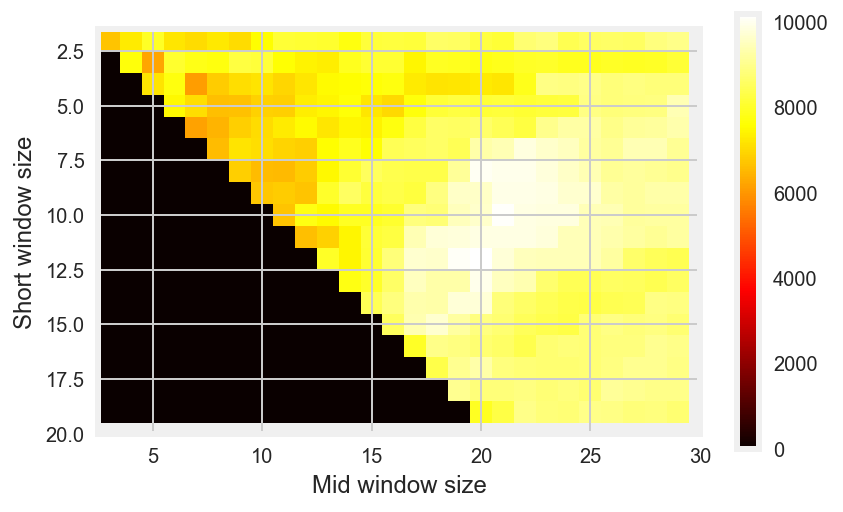

In [11]:
max_sh_wind, max_mid_wind = (20, 30)
bal_ret = np.zeros([max_sh_wind, max_mid_wind])
for sh in range(1,max_sh_wind):
    for mid in range(1,max_mid_wind):
        if sh<mid:
            bal_ret[sh,mid] = DMAC_trading_return(btc_close.loc[:'2017-12-01'],
                                sh,
                                mid,
                                with_plot=False)

plt.imshow(bal_ret, cmap="hot")            
plt.xlabel('Mid window size')
plt.ylabel('Short window size')
plt.xlim([2.5,max_mid_wind])
plt.ylim([max_sh_wind,1.5])
plt.colorbar()

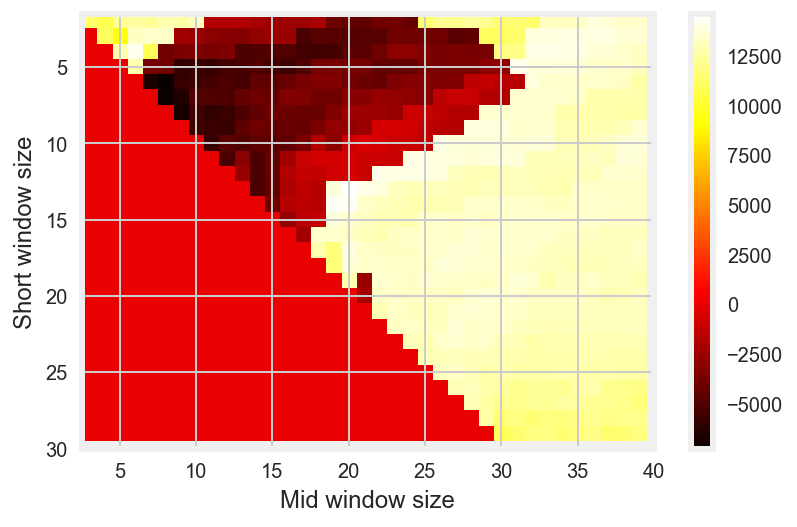

In [14]:
max_sh_wind, max_mid_wind = (30, 40)
bal_ret = np.zeros([max_sh_wind, max_mid_wind])
for sh in range(1,max_sh_wind):
    for mid in range(1,max_mid_wind):
        if sh<mid:
            bal_ret[sh,mid] = DMAC_trading_return(btc_close,
                                sh,
                                mid,
                                with_plot=False)

plt.imshow(bal_ret, cmap="hot")            
plt.xlabel('Mid window size')
plt.ylabel('Short window size')
plt.xlim([2.5,max_mid_wind])
plt.ylim([max_sh_wind,1.5])
plt.colorbar()